╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱
<br>
╭╮╱╭╮╱╱╭╮╭╮╱╱╱╱╭━━━╮╱╱╱╱╱╱╱╱╱╱╱╭╮╱╱╱╭╮╱╱╱╭╮
<br>
┃┃╱┃┃╱╱┃┃┃┃╱╱╱╱┃╭━╮┃╱╱╱╱╱╱╱╱╱╱╱┃┃╱╱╭╯╰╮╱╱┃┃
<br>
┃╰━╯┣━━┫┃┃┃╭━━╮┃╰━━┳━━┳━━┳━━┳╮╭┫┃╭━┻╮╭╋━━┫┃
<br>
┃╭━╮┃┃━┫┃┃┃┃╭╮┃╰━━╮┃╭╮┃┃━┫╭━┫┃┃┃┃┃╭╮┃┃┃┃━╋╯
<br>
┃┃╱┃┃┃━┫╰┫╰┫╰╯┃┃╰━╯┃╰╯┃┃━┫╰━┫╰╯┃╰┫╭╮┃╰┫┃━╋╮
<br>
╰╯╱╰┻━━┻━┻━┻━━╯╰━━━┫╭━┻━━┻━━┻━━┻━┻╯╰┻━┻━━┻╯
<br>
╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱┃┃╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱
<br>
╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╰╯╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱╱
<br>

## **Speculate Cookbook Guide**

#### *Goal:* Rapid emulation of a model spectrum through a pre-defined grid space given an observed spectrum.

With this cookbook, we describe the implimation of the original Starfish code, the changes we have done to allow a python gridspace to work and the expected variables needed from the code to insure correct operation. 

The code is broken up into stages for ease of reading from 1 to X. Most lines of code has a comment to hint at what is happening at that point. 

For rapid modelling (avoiding the training steps), run only these stages.


#### <u>**Stage 1** - The Imports and Functions</u>

This code block imports all the modules necessary, defines required classes for the python grid interface and has some further functions. 

For my installation, I'm using a conda environment with python 3.9.13 and Starfish version 0.4.2 (most up to date version 4/4/23). See installation instructions for Starfish here: https://github.com/Starfish-develop/Starfish. You are needed to also install emcee ($conda install -c conda-forge emcee), arviz ($conda install -c conda-forge arviz) and corner($conda install -c astropy corner)

Once installed and verified, download the require "kgrid" folder for the cataclysmic variable (ss_cygni) grid space. The code is setup for a folder to contain this notebook with the kgrid folder. If the notebook and grid data is saved differently, the **path='kgrid/sscyg_kgrid090311.210901/'** variable in stage 2 will have to amended to your setup. 

###### Eigenplotting to be added

##### Note:
With this build for faster computation time, we smoothen the spectral flux of every grid point file. Smoothening is achieved by applying the `scipy.ndimage.gaussian_filter_1D()` within the `load_flux` function. The filter takes as inputs, the flux array and a value for the standard deviation of the gaussian kernel which smoothens the flux. I have set the standard deviation to 5, which seems to have a balance of computational time, detail in the spectrum and reducing autocorrelation in the pixels. This runs okay with 3, 4, maybe even 5 parameters. However, you may want to increase this to $10-50\sigma$ for faster computational time when testing with 6 parameters. 

In [14]:
"""1) Importing modules and custom functions"""

import numpy as np
import Starfish
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha
from Starfish.grid_tools import download_PHOENIX_models
from Starfish.grid_tools.instruments import SPEX
from Starfish.grid_tools import HDF5Creator
from Starfish.emulator import Emulator
from Starfish.emulator.plotting import plot_emulator
from Starfish.emulator.plotting import plot_eigenspectra
import matplotlib.pyplot as plt
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
import scipy.stats as st
import emcee
import arviz as az
import corner
import time
import matplotlib
import itertools
from tqdm import tqdm
import random
#Surya
import h5py
import os
from Starfish.grid_tools import GridInterface
from scipy.ndimage import gaussian_filter1d
from multiprocessing import Pool
from multiprocessing import cpu_count

class KWDGridInterface(GridInterface):
    """"
    An Interface to the KWD grid produced by PYTHON simulation.
    
    The wavelengths in the spectra are in Angstrom and fluxes in erg/s/cm^2/cm
    
    Parameters of model
    -------------------
    1) wind.mdot (msol/yr)
    2) kn.d
    3) kn.mdot_r_exponent
    4) kn.v_infinity (in_units_of_vescape)
    5) kn.acceleration_length (cm)
    6) kn.acceleration_exponent
    
    Optional parameters
    -------------------
    angle of inclination (taken to be 40.0 for this analysis)
    
    """
    
    def __init__(self, path, air=False, wl_range=(1200,1800), model_parameters=(1,2,3)):
        """"
        Initialises an empty grid with parameters and wavelengths.
        
        Parameters
        ----------
        path : str or path-like
            The path of the base of the KWD library.
        air : bool, optional
            Whether the wavelengths are measured in air or not. Default is False
            (Required due to implementation of inherited GridInterface class)
        wl_range : tuple, optional
            The (min, max) of the wavelengths in AA. Default is (1200, 1400) for testing.
        model_parameters : tuple, optional
            Specifiy the parameters you wish to fit by adding intergers to the tuple. 
        """
        # The grid points in the parameter space are defined, 
        # param_1-6_points correspond to the model parameters defined at the top in the respective order.
        self.model_parameters = model_parameters
        points = []
        if 1 in model_parameters:
            param_points_1 = np.array([1e-10, 1.5e-10, 2.1e-10, 3.1e-10, 4.5e-10, 6.6e-10, 9.7e-10, 1.4e-09, 2.1e-09, 3e-09])
            points.append(param_points_1)
        if 2 in model_parameters:
            param_points_2 = np.array([4, 16, 32])
            points.append(param_points_2)
        if 3 in model_parameters:
            param_points_3 = np.array([0, 0.5, 1])
            points.append(param_points_3)
        if 4 in model_parameters:
            param_points_4 = np.array([1, 2, 3])
            points.append(param_points_4)
        if 5 in model_parameters:
            param_points_5 = np.array([1e+10, 3e+10, 7e+10])
            points.append(param_points_5)
        if 6 in model_parameters:
            param_points_6 = np.array([1, 3, 6])
            points.append(param_points_6)
            
        param_names = ["param{}".format(number) for number in model_parameters] # formatting the parameter names

        # Inititalising the GridInterface with the KWD parameters.
        super().__init__(
            name='KWD',
            param_names=param_names,
            points=points,
            wave_units='AA',
            flux_units='erg/s/cm^2/cm',
            air=air,
            wl_range=wl_range,
            path=path,
        )
        
        # The wavelengths for which the fluxes are measured are retrieved.
        try:
            wls_fname = os.path.join(self.path, 'sscyg_k2_000000000000.spec')
            wls = np.loadtxt(wls_fname, delimiter=' ', usecols=(1), skiprows=2)
            wls = np.flip(wls)
        except:
            raise ValueError("Wavelength file improperly specified")
        
        # Truncating to the wavelength range to the provided values.
        self.wl_full = np.array(wls, dtype=np.float64) #wls[::-1]
        self.ind = (self.wl_full >= self.wl_range[0]) & (
            self.wl_full <= self.wl_range[1])
        self.wl = self.wl_full[self.ind]
        
        #self.rname = ""
        #self.full_rname = os.path.join(self.path, self.rname)
        
        
    def get_flux(self, params):
        """"
        Constructs path of datafile corresponding to parameters passed.
        
        Parameters
        ----------
        params : ndarray
            Contains the parameters of a required grid point.
            
        Returns
        -------
        str
            The path of the datafile corresponding to the input parameters.
            
        """
        #param_names = ["c{}".format(number) for number in parameter_numbers]
        # dict file name format for different param values.
        param1_name = {1e-10: '00', 1.5e-10: '01', 2.1e-10: '02', 3.1e-10: '03', 4.5e-10: '04',
                       6.6e-10: '05', 9.7e-10: '06', 1.4e-09: '07', 2.1e-09: '08', 3e-09: '09'}
        param2_name = {4: '00', 16: '01', 32: '02'}
        param3_name = {0: '00', 0.5: '01', 1: '02'}
        param4_name = {1: '00', 2: '01', 3: '02'}
        param5_name = {1e+10: '00', 3e+10: '01', 7e+10: '02'}
        param6_name = {1: '00', 3: '01', 6: '02'}
        all_names = [param1_name, param2_name, param3_name, param4_name, param5_name, param6_name] # Can be improved with dictionary
        param_numbers = params
        base = self.path + 'sscyg_k2_'
        for loop in range(6):
            if "param{}".format(loop+1) in self.param_names:
                base += all_names[loop][param_numbers[loop]]
            else:
                base += '00'
                param_numbers = np.insert(param_numbers, loop, 0)          
        return base + '.spec'

    def parameters_description(self, model_parameters):
        """Provides a description of the model parameters used.

        Args:
            model_parameters (tuple): Numbers of the parameters used in the model.

        Returns:
            dictionary: Description of the 'paramX' name
        """
        dictionary = {
            1:"wind.mdot (msol/yr)",
            2:"kn.d",
            3:"kn.mdot_r_exponent",
            4:"kn.v_infinity (in_units_of_vescape)",
            5:"kn.acceleration_length (cm)",
            6:"n.acceleration_exponent"
            } #Description of the paramters
        parameters_used = {}
        for i in model_parameters:
            parameters_used["param{}".format(i)] = dictionary[i]
        return parameters_used
        
    def load_flux(self, parameters, header=False, norm=False, angle_inc=0):
        """"
        Returns the Flux of a given set of parameters.
        
        Parameters
        ----------
        parameters : ndarray
            Contains parameters of a required grid point
            
        header : bool
            Whether to attach param values on return
            
        norm : bool
            Whether to normalise the return flux (left unimplemented)
            
        angle_inc : int
            Angle of inclination, takes values between 0 to 6 corresponding
            to values between 40.0 and 70.0 with 5.0 degree increment.
            
        Returns
        -------
        ndarray
            List of fluxes in the wavelength range specified on initialisation
            
        dict (Optional)
            Dictionary of parameter names and values
        
        """
        from scipy.ndimage import gaussian_filter1d # Instead of normalising, a 1d gaussian smoothing filter is applied 
        flux = np.loadtxt(self.get_flux(parameters), usecols=(8+angle_inc), skiprows=2)
        flux = np.flip(flux)
        flux = gaussian_filter1d(flux, 5)
        
        hdr = {'c0' : angle_inc} # Header constructed (channel 0 corresponds to angle of inclination)
        for i in range(len(self.param_names)):
            hdr[self.param_names[i]] = parameters[i]

        if(header):
            return flux[self.ind], hdr
        else:
            return flux[self.ind]

def plot_emulator(emulator, model_parameters, not_fixed):
    
    # Placing the grid points values within a dictionary, keyed as 'params{}'
    variables = {}
    for loop in model_parameters:
        variables["param{}".format(loop)] = np.unique(emulator.grid_points[:, model_parameters.index(loop)])
        
    # Creating a custom itertools.product routine which can dynamically input the free varying parameter
    # and the length of the number of parameters depending on what is specified. 
    # params = np.array(list(itertools.product(T, logg[:1], Z[:1]))) # <-- starfish original
    not_fixed_index = model_parameters.index(not_fixed) # Converting parameter number to index position
    params = []
    temp = [variables[emulator.param_names[j]] for j in range(len(variables))] # Creating list from dictionary
    # New list fixing the other parameters on the first grid point↓
    temp2 = [np.array(temp[i]) if i==not_fixed_index else temp[i][0] for i in range(len(temp))] # <--- Change the 0 in temp[i][0] if you wish to see other fixed parameters indexes
    for j in range(len(temp2[not_fixed_index])): # Itertools.product calculation into the same original formatting
        params.append(tuple([temp2[i][j] if temp2[i].size>1 else temp2[i] for i in range(len(temp2))]))
    params = np.array(params)
    
    idxs = np.array([emulator.get_index(p) for p in params])
    weights = emulator.weights[idxs.astype("int")].T
    if emulator.ncomps < 4:
        fix, axes = plt.subplots(emulator.ncomps, 1, sharex=True, figsize=(8,(emulator.ncomps-1)*2))
    else:
        fix, axes = plt.subplots(
            int(np.ceil(emulator.ncomps/2)), 2, sharex=True, figsize=(13,(emulator.ncomps-1)*2),)
    axes = np.ravel(np.array(axes).T)
    [ax.set_ylabel(f"$weights_{i}$") for i, ax in enumerate(axes)]
    
    param_x_axis = np.unique(emulator.grid_points[:,not_fixed_index])
    for i, w in enumerate(weights):
        axes[i].plot(param_x_axis, w, "o")
        
    # Again as above, dynamical input for the gaussian process errors to be plotted for the specified parameter
    param_x_axis_test = np.linspace(param_x_axis.min(), param_x_axis.max(), 100)
    temp2[not_fixed_index] = param_x_axis_test
    Xtest = []
    for j in range(len(temp2[not_fixed_index])):
        Xtest.append(tuple([temp2[i][j] if temp2[i].size>1 else temp2[i] for i in range(len(temp2))]))
    Xtest = np.array(Xtest)
    mus = []
    covs = []
    for X in Xtest:
        m, c = emulator(X)
        mus.append(m)
        covs.append(c)
    mus = np.array(mus)
    covs = np.array(covs)
    sigs = np.sqrt(np.diagonal(covs, axis1=-2, axis2=-1))
    for i, (m, s) in enumerate(zip(mus.T, sigs.T)):
        axes[i].plot(param_x_axis_test, m, "C1")
        axes[i].fill_between(param_x_axis_test, m - 2 * s, m + 2 * s, color="C1", alpha = 0.4)
        axes[i].set_xlabel("Parameter{}".format(not_fixed))
    plt.suptitle("Weights for Parameter{} with the other parameters fixed to their zero index grid point".format(not_fixed), fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def newlagtimes(x,y,maxlags):
    """Normalised Correlation of two lightcurve arrays using the entire lightcurve dataset
    Austen's previously made cross correlation routine. Auto formats datasets. Instant output. 'Same' method.
    Use the same dataset for x and y if you wish to find the Autocorrelation
    
    Args:
        x (numpy array): 1D array of timeseries/data for cross-correlation
        y (numpy array): 1D array of timeseries/data for cross-correlation. 
        Input the same x data here for auto-correlation
        maxlags (int): Maximum number of lags you wish to be generated. 
        The maximum this can be is the length of your array
    """
    
    def ccf(x,y):
        """CCF for two equally sized arrays"""
        N=0
        summation=0
        meanx = np.average(x)
        meany = np.average(y)
        variancex = np.var(x)
        variancey = np.var(y)
        for valuex, valuey in zip(x, y):
            N = N+1
            summation = summation + ((valuex - meanx)*(valuey - meany))
        ratio = summation/(np.sqrt(variancex*variancey)*N)
        return ratio   
    
    resultarray = [] #initalising parameters
    lagtimearray = np.arange(-maxlags, maxlags+1, 1) #lag times for plot
    lenlagarray = np.arange(0, len(lagtimearray),1) #iteration loop
    if len(x) < len(y):                             #x array is smaller than y array and moves across y
        for iteration in lenlagarray:
            if iteration > maxlags:                 #positive lags
                index = int(iteration - maxlags)    #iterating index for the array slicing 
                ysliced = y[index:]                 #cutting up the arrays for equal lenghts
                if len(ysliced) < len(x):
                    xsliced = x[:len(ysliced)]
                    resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #performing ccf
                else:
                    ysliced = y[index:len(ysliced)]
                    resultarray = np.append(resultarray, ccf(x, ysliced)) #permforming ccf
                    
            else: #negative lags
                index = int(-1*(iteration-maxlags))     #iterating index for the array slicing
                xsliced = x[index:]                     #cutting front of the array off for negative lags
                ysliced = y[:len(xsliced)]              #cutting the end off of other for equal lenght
                resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #permoforming ccf
                
            
    elif len(x) > len(y): #x array is larger than y array and moves across y
        for iteration in lenlagarray:
            if iteration > maxlags:                 #positive lags
                index = int(iteration - maxlags)    #iterating index for the array slicing 
                ysliced = y[index:]                 #cutting up the arrays for equal lenghts
                xsliced = x[:len(ysliced)]
                resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #performing ccf
                    
            else: #negative lags
                index = int(-1*(iteration-maxlags))     #iterating index for the array slicing
                xsliced = x[index:]                     #cutting front of the array off for negative lags
                if len(xsliced) < len(y):    
                    ysliced = y[:len(xsliced)]              #cutting the end off of other for equal lenght
                    resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #permoforming ccf
                else:
                    xsliced = x[index:len(xsliced)]
                    resultarray = np.append(resultarray, ccf(xsliced, y)) #permoforming ccf
                    
    else:
        for iteration in lenlagarray:
            if iteration > maxlags:                 #positive lags
                index = int(iteration - maxlags)    #iterating index for the array slicing 
                ysliced = y[index:]                 #cutting up the arrays for equal lenghts
                xsliced = x[:len(ysliced)]
                resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #performing ccf            
            
            else: #negative lags
                index = int(-1*(iteration-maxlags))     #iterating index for the array slicing
                xsliced = x[index:]                     #cutting front of the array off for negative lags
                ysliced = y[:len(xsliced)]              #cutting the end off of other for equal lenght
                resultarray = np.append(resultarray, ccf(xsliced, ysliced)) #permoforming ccf  
    return lagtimearray, resultarray


#### <u>**Stage 2** - Setting up the Grid Space</u>

This code block sets up our python grid space in a HDF5 file, given the formatting within 'kgrid', to work with the Starfish framework.

We use the class called 'KWDGridInterface' which can read the spectrum files (.spec) within 'kgrid/sscyg_kgrid090311.210901/'.

-- You have two inputs here! --

The first is `model_parameters`. This is a tuple of the model parameters you wish to use for the emulator. You can input parameters in any order. Thoughout the code, the more parameters you have, the slower the computational time (scaling likely $O(n^3)$ due to the gaussian process training). 3 to 4 inputs are quite fast. Each parameter has a associated number here:

    1) wind.mdot (msol/yr)
    2) kn.d
    3) kn.mdot_r_exponent
    4) kn.v_infinity (in_units_of_vescape)
    5) kn.acceleration_length (cm)
    6) kn.acceleration_exponent

Your second input is the wavelength range of your emulator grid space. This should be slightly smaller (or equal) than the wavelength range of your python grid space for general use. If you only want your emulator on a smaller part of the wavelength space, you can reduce this range input to reduce computational time. 

##### Note:
In future, if a different grid with the same formatting is used, you would need to change in stage 1: 
- 'The grid points in the parameter space' in `def __init__:`. 
- The example file naming scheme 'sscyg_k2_000000000000.spec' in `super().__init__()`. 
- The grid point's corresponding number in the file name eg, 1e-10: '00' and range(value) in the for loop depending on the number of parameters in `get_flux():`.

Follow the original naming scheme for all changes, **if** made. 

In [15]:
"""2) - Set up your grid space! - 
        Parameters of model
        -------------------
        1) wind.mdot (msol/yr)
        2) kn.d
        3) kn.mdot_r_exponent
        4) kn.v_infinity (in_units_of_vescape)
        5) kn.acceleration_length (cm)
        6) kn.acceleration_exponent
"""
    
### ----- Inputs here ------|
model_parameters=(3,1,5,4)  # Parameters shown above
wl_range = (900,1800)       # Wavelength range of your emulator grid space kgrid:(min, max)=(876,1824)
### ------------------------|

model_parameters = sorted(model_parameters) # Sorting parameters by increasing order
grid = KWDGridInterface(path='kgrid/sscyg_kgrid090311.210901/', wl_range=wl_range,
                        model_parameters=model_parameters) # Grid space function

# Faster processing with python's .spec files into a hdf5 file
keyname = ["param{}{{}}".format(i) for i in model_parameters]   # Auto-generated keyname's from parameters
keyname = ''.join(keyname)                                      # Keyname required to integrate with Starfish 
creator = HDF5Creator(grid, 'KWD_Grid_full_ss_cyg.hdf5', key_name=keyname, wl_range=wl_range) # Processing grid function
creator.process_grid()


Processing [3.e-09 1.e+00 3.e+00 7.e+10]: 100%|██████████| 270/270 [00:12<00:00, 22.26it/s]    


#### <u>**Stage 3** - Generating and Training the Emulator</u>

This code block generates your emulator's grid from PCA decomposition and trains the emulator's hyperparameters by gradient decent with scipy.optimize.minimise. 

The `emu.train()` routine is complex and detailed in Appendix [Czekala et al. 2015](https://arxiv.org/pdf/1412.5177.pdf). However, the very brief summary is that we optimise the likelihood function for a set of extrinsic and model parameters. The weights from the PCA decomposition is treated as a grid. Then, a gaussian process treat the weights grid as draws from a multivariate Gaussian distribution, with a square exponential kernel defining the hyperparameters. 

The 'scipy.optimise.minisise' routine chosen by Starfish devs was the 'Nelder-Mead' routine, with a maximum number of 1e5 iterations. This iteration number can be changed by `maxiter=`. To note, the `log_likelihood` function within the training uses scipy's linear algebra module (`scipy.linalg`) by doing cho factor calculations. The linear algebra module has parallization built in so these calculations scales to the number of CPU's you have ($CPU_{X}-2$). 

-- You have one input here! --

`n_components` controls the number of components (eigenspectra) you wish to truncte to when performing your PCA decomposition. You can specify the number of eigenspectra generated by setting a integer between 1 to the maximum number of grid points. You could also specify the number of components between 0.01-0.99. A decimal will let the PCA truncate the number of eigenspectra to the percentage of variance described by the decimal. E.g. 0.85 will produce X number of eigenspectra that describes 85% of the variance. 
See the 'PCA with SVD workbook.pdf' if you need a reminder about the PCA method. 

In [4]:
"""3) Generating and training the emulator grid for modelling"""

### ----- Inputs here ------|
n_components = 4            # Alter the number of components in the PCA decomposition  
                            # Integer for no. of components or decimal (0.0-1.0) for 0%-100% accuracy. 
### ------------------------|

emu = Emulator.from_grid('KWD_Grid_full_ss_cyg.hdf5', n_components=n_components, svd_solver="full") # Emulator grid function
emu.train(options=dict(maxiter=1e5)) # Training the emulator grid, maximum iterations for the scipy.optimise.minimise routine
emu # Displays the trained emulator's parameters

PCA fit 0.74% of the variance with 4 components.


Emulator
--------
Trained: True
lambda_xi: 0.999
Variances:
	2692843.24
	393004.73
	113477.68
	33693.71
Lengthscales:
	[ 0.00  1.46  4.21  93522090587.96 ]
	[ 0.00  1.32  3.20  178472322725.05 ]
	[ 0.00  1.43  2.73  80000000448.78 ]
	[ 0.00  1.02  2.00  104666376160.27 ]
Log Likelihood: -2376.11

#### <u>**Stage 4** - Plotting the Emulator</u>

This code block simply plots out the eigenspectra generated from the PCA, the emulator's trained weights which utilised gaussian processes for the interpolation and saves the emulator for reuse later if require. This save re-running when the computational time is long. 

-- You have one input here! --

You can change which parameter weights are plotted by changing the corresponding parameters number in the `plot_emulator()` function. All the other parameters are fixed at the zero index grid point. 

If you wish to see more examples with the fixed parameters at other grid points, within Stage 1, find `temp2` in the `plot_emulator()` function as shown here:
`temp2 = [np.array(temp[i]) if i==not_fixed_index else temp[i][0] for i in range(len(temp))]`.
The 0 can be changed to any index value, however, make sure the index is less than or equal to the fixed parameter with the least grid points. The code isn't set up to take multiple different indexes for different parameters, they all share the same fixing index for plotting. So don't break this!


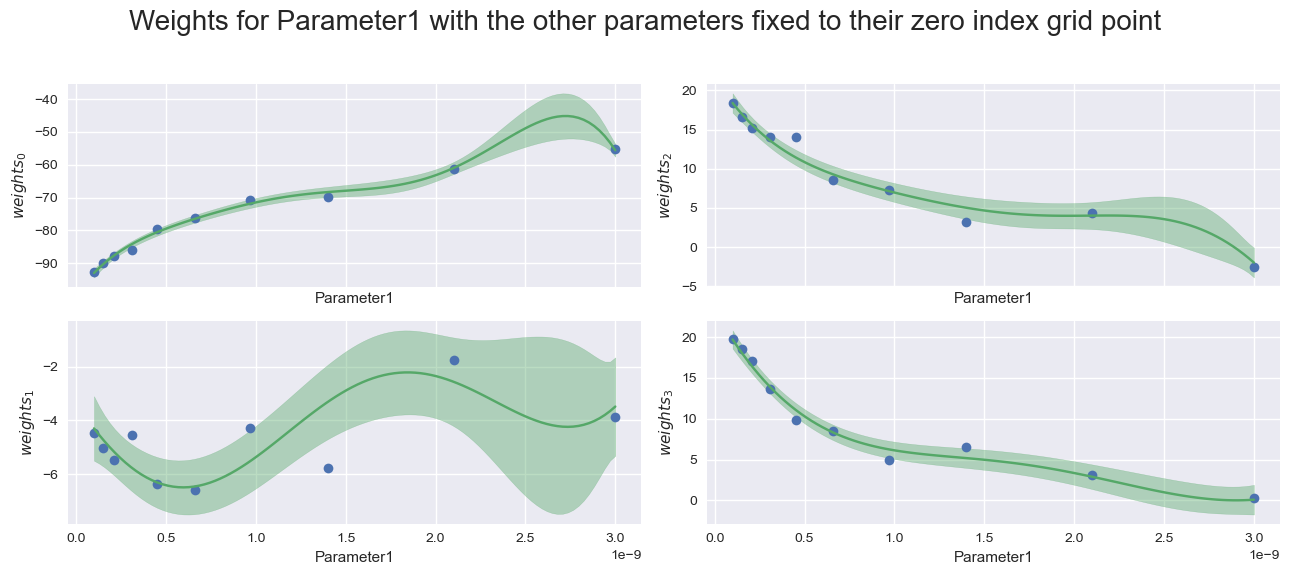

In [16]:
"""4) Plotting and saving the emulator"""

#plot_eigenspectra(emu, 0) # <---- Yet to implement
plot_emulator(emu, model_parameters, 1) # <---- Change which parameter is the x-axis, values in section 2
emu.save('KWD_emu_full_ss_cyg.hdf5')

#### <u>**Stage 5** - The Emulator's Covariance Matrix</u>

This code block isn't necessary for the emulator to work. However, may be interesting to you. A random set of emulator grid plots are chosen and the emulators covariance matrix is plotted. This is likely more useful as a diagnostic tool for when things might break or for some reason you wish to change the Gaussian processes' kernel. Again, described in Appendix [Czekala et al. 2015](https://arxiv.org/pdf/1412.5177.pdf). 

The code cell loads your emulator file, ensure this is the correct file you wished to view. Default in this notebook is the same file as saved in Stage 4.

Random Grid Point Selection
['param1', 'param3', 'param4', 'param5']
[4.5e-10 0.0e+00 1.0e+00 7.0e+10]


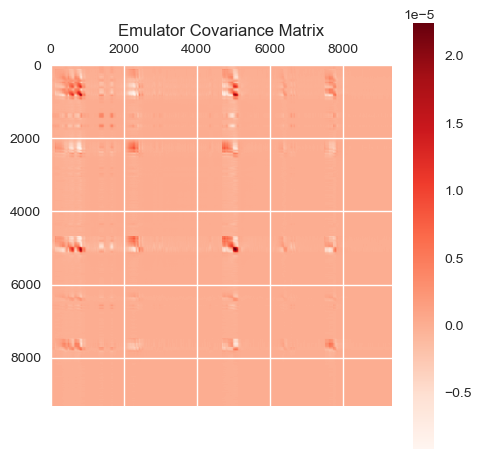

In [17]:
"""5) If you want to see the emulator covariance matrix for a grid point, run this cell"""

emu = Emulator.load("KWD_emu_full_ss_cyg.hdf5")
random_grid_point = random.choice(emu.grid_points)
print("Random Grid Point Selection")
print(list(emu.param_names))
print(random_grid_point)
weights, cov = emu(random_grid_point)
X = emu.eigenspectra * (emu.flux_std)
flux = (weights @ X) + emu.flux_mean
emu_cov = X.T @ cov @ X
plt.matshow(emu_cov, cmap='Reds')
plt.title("Emulator Covariance Matrix")
plt.colorbar()
plt.show()

#### <u>**Stage 6** - Reading in Observational Data or Generating Test Data</u>

This code block is now the point you would introduce your observed spectrum from your target. In our case here, there is four method options for what type of test spectrum you wish to model against. These spectrum are:

    1) A grid point 
    2) A noisy version of a grid point
    3) Interpolation between a few grid point spectrum (method detailed in section)
    4) A custom test file from python

-- You have four switches and four sets of inputs here depending on the four methods! --

For which method you choose, turn on (1) one of the data_(X) values. For the corresponding data_(X) input:

1) Takes a grid point file as the data spectrum. You only need to specify which grid point file you want. The 'kgrid' follows the naming scheme where each parameters grid points corresponds to a two digit value XX (eg 06). So every file for the 6 parameters 'kgrid' has a 12 digit string ordered as the parameters are in Stage 2. For a quick look up of the grid point/digit combination, within the definition for the `get_flux()` function in Stage 1, see the dictionary entries for the `param(X)_name`.
2) Similar to 1. This takes a specified grid point spectral file but adds random gaussian noise onto each flux value. You can control the level of noise with the `noise_std` input. The input changes the standard deviation (width) of the normal distribution, where $1\sigma$  is the standard deviation of all the flux values. 
3) Yet to be implemented! This will take a data file and it's nearest two index grid point files. These's three files are then interpolated to generate a new file as the data spectrum. Method to be detailed later. 
4) Similar to 1. This take a Python v87a spectral file. Ensure the file is located within the 'kgrid' folder. 

Upon completion a plot of your data spectrum should be shown. 

<AxesSubplot:title={'center':'Spectrum'}, xlabel='$\\lambda$ [$\\AA$]', ylabel='$f_\\lambda$ [$erg/cm^2/s/cm$]'>

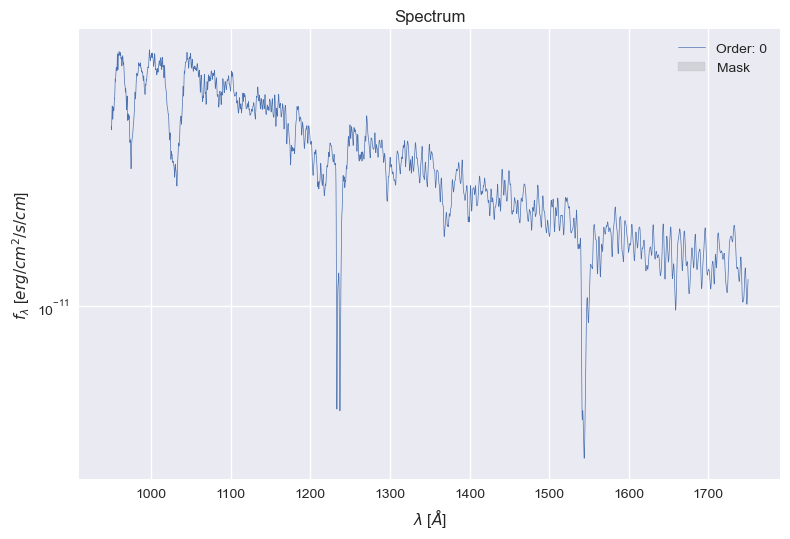

In [18]:
"""6) Producing test spectrum data for the emulator comparisons."""

"""Four methods to select which type of test spectrum file you want:
    1) A grid point 
    2) A noisy version of a grid point
    3) Interpolation between a few grid point spectrum (method detailed in stage 6)
    4) A custom test file from python
"""
### ----- Switches here ----|
                            # Turn off/on [0,1] to use this method
data_one = 0                # 1)                        
data_two = 1                # 2)                                               
data_three = 0              # 3) <--- Yet to implement!
data_four = 0               # 4) 
### ------------------------|

### ----------- Inputs here ------------|
# 1)
if data_one == 1:
    file = 'sscyg_k2_040102000000.spec' # < File corresponds to grid points in section 2 
                                        # < Parameter's point given by the XX number in the name (6 params = 12 digits)
# 2)                          
if data_two == 1:
    file = 'sscyg_k2_040102000000.spec' # < File naming same as 1)
    noise_std = 0.50                    # < Percentage noise (0.05 sigma)
# 3)                          
if data_three == 1:
    print('to do')
# 4)
if data_four == 1:
    file = 'ss_cyg_1.spec'              # Python v87a formatting. Place python file within kgrid folder/directory

### ------------------------------------|

if data_one == 1: 
    waves, fluxes = np.loadtxt(f'kgrid/sscyg_kgrid090311.210901/{file}', usecols=(1,8), unpack = True)
    
if data_two == 1: 
    waves, fluxes = np.loadtxt(f'kgrid/sscyg_kgrid090311.210901/{file}', usecols=(1,8), unpack = True)
    noise = noise_std * np.std(fluxes)
    for i in range(len(waves)):
        fluxes[i] = np.random.normal(fluxes[i], noise)
        
if data_three == 1:
    print('to do')
    
if data_four == 1:
    waves, fluxes = np.loadtxt(f'kgrid/{file}', unpack = True, usecols=(1,10), skiprows=74)



wl_range_data = (wl_range[0]+50, wl_range[1]-50)
waves = np.flip(waves)
fluxes = np.flip(fluxes)
indexes = np.where((waves >= wl_range_data[0]) & (waves <= wl_range_data[1]))
waves = waves[indexes[0]]
fluxes = fluxes[indexes[0]]
raw_flux = list(fluxes)
fluxes = gaussian_filter1d(fluxes, 5)
sigmas = np.zeros(len(waves))
data = Spectrum(waves, fluxes, sigmas=sigmas, masks=None)
data.plot()

#### <u>**Stage 7** - Autocorrelation within the Test Data</u>

This code block determines the pixel autocorrelation within your data spectrum. To accurately measure the autocorrelation, the data is passed through a high pass filter to remove trends within the spectrum that effects the result. You have two plots outputted. The plot showing the high-pass filter adjusted flux data and a plot showing the autocorrelation between pixels from your data. 

-- You have three inputs here! --

1) `high_pass_sigma`, similarly to the use of the `gaussian_filter1D` is stage 1, controls the value for the standard deviation of the gaussian kernel which smoothens the flux. The high pass filter's `gaussian_filter1d` function takes the already smoothened data from stage 1 and again applies the smoothening filter. As a result, the `high_pass_sigma` value should be multiples greater than the value used in stage 1 (defaulted at 5). The plot outputted from this stage can be run over and over again to improve the fitting performance of the high pass filter to the trend of the data. However, be warned! The higher the value of the `high_pass_sigma`, the trend in the high-pass filter wraps towards $y=c$ and no longer fits the data well. Too low of a value will result in remove detail from the spectrum. So a compromise has to be made between the two. This is purely a qualitative adjustmeant at the moment (room for improvement) and is left to the user for adjustment depending on their individual data case. 
2) `lags` is a simple input to control range of the pixel shift in the autocorrelation plot. The greater the value, the greater the comparison shift. The lags value gives positive and negative range, resulting in $-lags \leq 0 \leq +lags$.
3) `percent` controls the ability to cut strong spectral lines out of your high pass filter. If your data contains strong lines, the gaussian filter will be unable to smoothen out these lines 'bumps' with any reasonable value for the `high_pass_sigma`. As a result, you'll lose important correlation information at these line's wavelengths. The solution is to cut out the spectral line from the high-pass filter by using `percent`. (Method - Improvements likely to be implemented later). The spectrum is fit with a quadratic to unveil close to your data's trend. `Percent` controls the standard deviation boundary of the fit (eg. $0.5 = 0.5\sigma$ or $2 = 2\sigma$). These boundaries are plotted in $\color{orange}{\text{orange}}$. If any flux value crosses this boundary, that flux value +/- 10 of the neighbouring pixels are changed to the quadratically fitted line's value plus 5% random gaussian noise. This is NOT to remove noise from your data, but just unexpected large spectral lines. 

#### Note
From previous work I had built my own ACF python function `newlagtimes`. This function is incredibly easy to understand and useful as the data adjustment is done within the function (Docstring description not right but it's just an ACF). However, I also include a version using numpy's correlation function for comparison. If you can only see one line plotted, this is good! It means the data matches between the two methods. Yay!

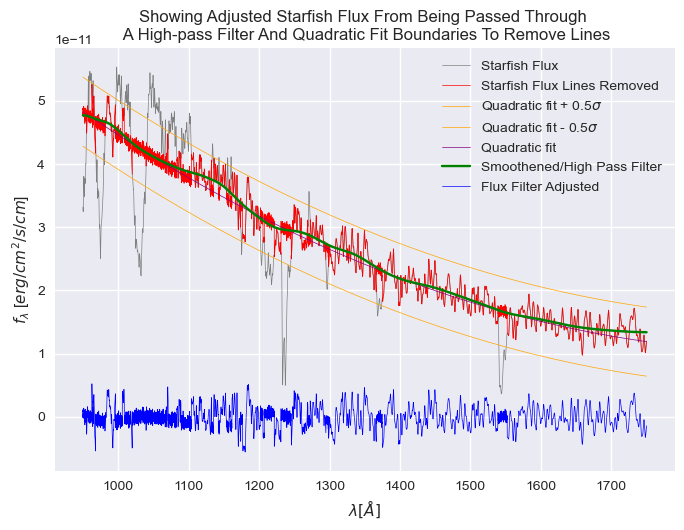

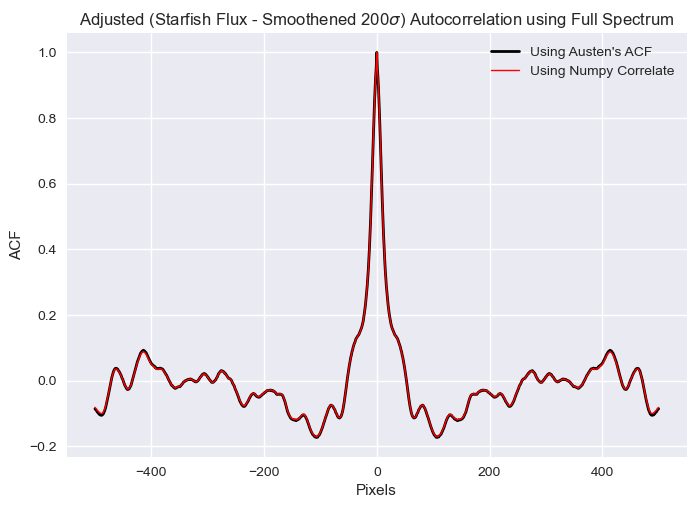

In [19]:
"""7 Measuring the autocorrelation of pixels """

### ----- Inputs here ------|
high_pass_sigma = 200       # Value of sigma (standard deviation) for the size of filter's gaussian kernel in the high pass filter. 
                            # The larger the value, the smoother the flux data but baseline can warp to y = c 
lags = 500                  # +/- range (aka lags) of the pixels for the autocorrelation plot.
percent = 0.5               # Specify the standard deviation of the quadratric fit boundaries to remove lines. 
### ------------------------|

def quadratic(x, coefficients):
    """Returns y value for a given x value and coefficients of a quadratic"""
    return coefficients[0]*(x**2) + coefficients[1]*(x) + coefficients[2]


# Alter startfish_flux sigma too (↓) if changing the smoothening term in the class KWDGridInterface(GridInterface):
starfish_flux = gaussian_filter1d(raw_flux, 5)      # Smoothened data used for the emulator input
starfish_flux_original = list(starfish_flux)        # Really weird bug if not with list! 
coefficients = np.polyfit(waves, starfish_flux, 2)  # Coefficients of a quadratic fitting routine
fit = [quadratic(i, coefficients) for i in waves]   # Y values for the quadratic best fit
std1 = np.std(fit)                     # Percent standard deviation of best fit
fit_err_plus = fit + (percent * std1)  # Plus 1 standard deviation of best fit for detecting lines
fit_err_minus = fit - (percent * std1) # Minus 1 standard deviation of best fit for detecting lines

# Cutting out large emission/absorption lines. Not efficient but too fast to worry about. Reduces large bumps in high pass filter
# Fluxes greater than 1 std have indexes +/- 10 intervals flux values replaced by the quadratic fit+noise. 
out_of_bounds_indexes = [1 if starfish_flux[i]>=fit_err_plus[i] or 
                         starfish_flux[i]<=fit_err_minus[i] else 0 for i in range(len(waves))] # Detecting lines >1std from fit
for i in range(len(waves)):
    if out_of_bounds_indexes[i] == 1:
        if i<10: # if/elif/else statement checking boundaries to stop errors
            waves_limit = range(0, i+11)
        elif i>(len(waves)-11):
            waves_limit = range(i-10, len(waves))
        else:
            waves_limit = range(i-10, i+11)
        for j in waves_limit: # +/- 10 flux intervals
                starfish_flux[j] = np.random.normal(fit[j], (0.05*std1)) # change line flux with fit flux plus 5% noise.    
                
smooth_flux = gaussian_filter1d(starfish_flux, high_pass_sigma) # High-pass filter for the starfish flux trend. 
adj_flux = starfish_flux - smooth_flux # Starfish data with underlying flux removed. 

plt.plot(waves, starfish_flux_original, color = "grey", label='Starfish Flux', linewidth=0.5)
plt.plot(waves, starfish_flux, color='red', label='Starfish Flux Lines Removed', linewidth=0.5)
plt.plot(waves, fit_err_plus, color='orange', label=f'Quadratic fit + {percent}$\sigma$', linewidth=0.5)
plt.plot(waves, fit_err_minus, color='orange', label=f'Quadratic fit - {percent}$\sigma$', linewidth=0.5)
plt.plot(waves, fit, color='purple', label='Quadratic fit', linewidth=0.5)
plt.plot(waves, smooth_flux, color='green', label='Smoothened/High Pass Filter')
plt.plot(waves, adj_flux, color='blue', label='Flux Filter Adjusted', linewidth=0.5)
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title('Showing Adjusted Starfish Flux From Being Passed Through \n A High-pass Filter And Quadratic Fit Boundaries To Remove Lines')
plt.legend()
plt.show()

pixels1, autocorrelation = newlagtimes(adj_flux, adj_flux, lags) # Austen's custom Autocorrelation function. 
plt.plot(pixels1, autocorrelation, label="Using Austen's ACF", linewidth=2, color = 'black')
plt.title(f'Adjusted (Starfish Flux - Smoothened {high_pass_sigma}$\sigma$) Autocorrelation using Full Spectrum')
plt.ylabel('ACF')
plt.xlabel('Pixels')

# Numpy's autocorrelation method for comparison checks.  
mean = np.mean(adj_flux)
var = np.var(adj_flux)
ndata = adj_flux - mean
acorr = np.correlate(ndata, ndata, 'same')
acorr = acorr /var/ len(ndata)
pixels = np.arange(len(acorr))
if len(acorr)%2 ==0:
    pixels = pixels - len(acorr)/2
else:
    pixels = pixels - len(acorr)/2 +0.5
indx = int(np.where(pixels == 0)[0])
lagpixels = pixels[indx-lags:indx+lags+1]
lagacorr = acorr[indx-lags:indx+lags+1]
plt.plot(lagpixels, lagacorr, color='red', label='Using Numpy Correlate', linewidth=1)
plt.legend()
plt.show()

#### <u>**Stage 8** - Kernel Calculators</u>

This code block is calculators which give estimate global kernel values for the next code block in stage 9. A full description will be given in stage 9, but the original method by the starfish was to repeatedly guess values until you find a good value. Starfish's read-the-docs also don't help as the example given does not tally up with the latest code release. The calculator should do the work, however, visually check the values in stage 9 still to be sure. 

THE CALCULATORS ARE YET TO BE IMPLIMENTED 
list of possible grid_params
log_amp calculator 
log_ls calculator

In [20]:
"""8 Calculators to determine reasonable estimates for log_amp and log_ls values"""

# Add code

'8 Calculators to determine reasonable estimates for log_amp and log_ls values'

In [21]:
"""8.2 Search grid point indexes for Stage 9"""
search_grid_points = 0 # Make sure to set to 0 if running a remote session!!!
if search_grid_points == 1:
    print("Search different indexes to find the associated grid point values")
    print("Index range is from 0 to {}".format(len(emu.grid_points)-1))
    print("Type '-1' to stop searching")
    print("Increasing the index increases the parameters grid points like an odometer")
    print("--------------------------------------------------------------------------")
    print("Names:", emu.param_names)
    print("Description:", [grid.parameters_description(model_parameters)[i] for i in emu.param_names])
    while True:
        index = int(input("Enter index input"))
        if index == -1:
            break
        elif 0 <= index <= len(emu.grid_points):
            print("Emulator grid point index {}".format(index))
            print(emu.grid_points[index])
        else:
            print("Not valid input! Type integer between 0 and {} or '-1' to quit".format(len(emu.grid_points)-1))

#### <u>**Stage 9** - Assigning the Model with the Emulator and Data</u>

This block of code is first point we assign our model. `SpectrumModel` is a class which stores as a variable, our emulator we have generated, the observation data we have read in (test data) and initial parameter guesses for our emulator to match the data BEFORE training. Let's go through each one by one! There are five (more *args optional) needed arguements for `SpectrumModel`
1) The name of your emulator file - This is a string of the file name we saved our emulator as in Stage 4. Other emulators could be loaded here if compatible formatting in the wavelength/grid space.
2) The observation data (test data) variable - This is set for you in stage 6. 
3) `grid_params = [...]` - This is an initial grid point guess for the emulator to match up with the test data. It's necessary in order to set-up parameter dictionarys within the Class. If you call `model.plot()`, you can see how the output changes with different emulator grid points when compared to the test data. However, the exact grid point used isn't important as the model is trained in a later stage.
4) `global_cov=dict(log_amp=X)` -  The `log_amp` is setting the global convariance kernel's amplitude value as a natural logarithm (ln, not log as code by Starfish, Changes to be implemented). The kernel used is the Matern 3/2 kernel defined in velocity space [km/s] (using velocity separation between pixels), where +3/2 is the half integer for the Matérn class of kernels. The value needs to be changed so the standard deviation contours in the top right residuals plot look reasonable ($\Delta f_{\lambda}$). This initial guess is for better training of the model in later stages. (The contours look very flat at the moment given the data. Need to investigate.)
5) `global_cov=dict(log_ls=X)` - The `log_ls` is setting the global convariance kernel's lengthscale value as a natural logarithm (ln, not log as code by Starfish, Changes to be implemented). The trunction of the Hann window in the global kernel is operated by a lengthscale multiple (6 times default). This controls the sparseness of the covariance matrix. 

The cell also outputs the plot of the global convariance matrix and the sum of the covariance matrices with the emulator's matrix. (check).

You are able to freeze any hyperparameter to remain fixed when training with `model.freeze("X")`. The list of available hyperparameters can be found by using `model.get_param_dict`. 



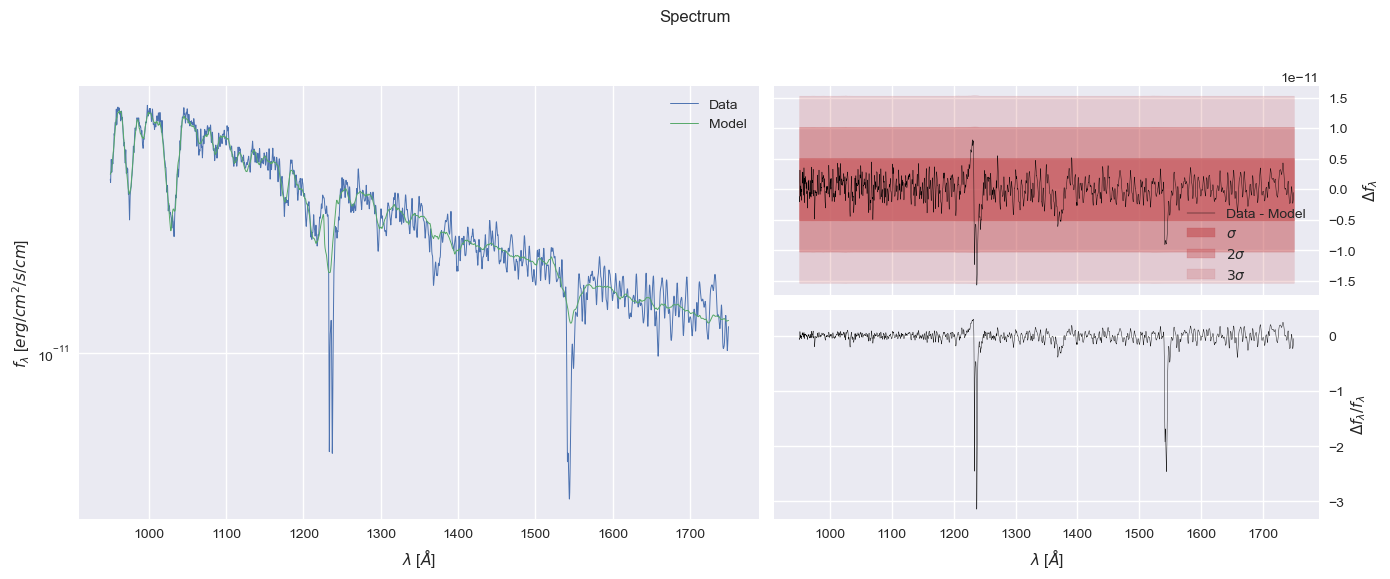

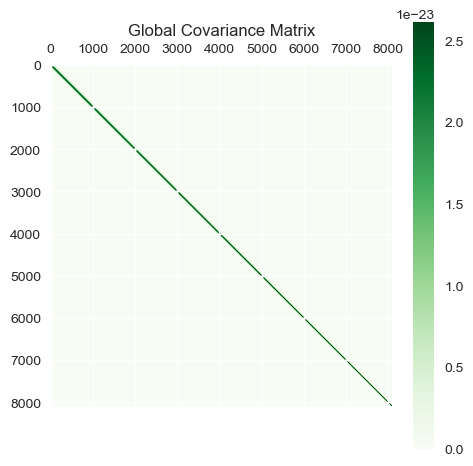

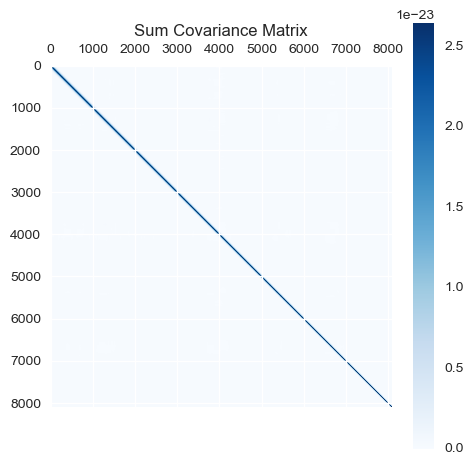

-- Model Labels --


('global_cov:log_amp',
 'global_cov:log_ls',
 'param1',
 'param3',
 'param4',
 'param5')

In [22]:
"""9 Assigning the model and initial model plot"""

### ----- Inputs here ------|
log_amp = -52               # Natural logarithm of the global covariance's Matern 3/2 kernel amplitude
log_ls = 5                  # Natural logarithm of the global covariance's Matern 3/2 kernel lengthscale
### ------------------------|

model = SpectrumModel(
    'KWD_emu_full_ss_cyg.hdf5',
    data,
    grid_params=list(emu.grid_points[10]), #[list, of , grid , points]
    Av=0,
    global_cov=dict(log_amp=log_amp, log_ls=log_ls)
)
model
model.plot()
model_flux, model_cov = model()
plt.matshow(model._glob_cov, cmap='Greens')
plt.title("Global Covariance Matrix")
plt.colorbar()
plt.show()
plt.matshow(model_cov, cmap='Blues')
plt.title("Sum Covariance Matrix")
plt.colorbar()
plt.show()
model.freeze("Av")
print("-- Model Labels --")
model.labels

#### <u>**Stage 10** - Assigning the Priors for MLE and MCMC</u>

This code block assigns the hyperparamter priors for when we perform MCMC on the model to determine their values. 

The recommendation is to largely use uniform priors across the parameter range unless certain of a result. The local kernel priors are recommended as uniform except for the width parameter. The width is logistic and at values below line-of-sight velocity distribution is flat. Above tapers to 0. This lets the global kernel do its work without local kernels attempting to interfere. 

Ensure the priors are within the grid parameter space! **Be warned**! With `st.uniform` the range is set by (x, y) where the distribution range will be from [$x$ to $x+y$].

(check why we don't specify local priors here)

In [23]:
"""10 Assigning the priors"""

# Default_priors contains a distribution for every possible parameter
# Mostly uniform across grid space bar global_cov being normal
# Change the default distrubtion if you wish something different. 
default_priors = {
    "param1": st.uniform(1.0e-10,2.9e-9),
    "param2": st.uniform(4, 28), 
    "param3": st.uniform(0.0, 1.0),
    "param4": st.uniform(1.0, 2.0),
    "param5": st.uniform(1e+10, 6e+10),
    "param6": st.uniform(1.0, 5.0),
    "global_cov:log_amp": st.norm(log_amp, 10),
    "global_cov:log_ls": st.uniform(0, 10),
    "Av": st.uniform(0.0, 1.0)
    }

priors = {} # Selects the priors required from the model parameters used
for label in model.labels:
    if label in default_priors:
        priors[label] = default_priors[label]

#### <u>**Stage 11** - Training the Model for Estimating Likelihood and Posteriors (MLE/MAP)</u>

This code block triggers the training of the model and priors we just made. The `train` function calculates the maximum likelihood estimate for the model in it's current state. Then with scipy.minimize.optimise, the model continues to estimate the posterior distribution through the maximum a posterior. 

In [24]:
"""11 Training the model"""
model.train(priors)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: KWD_emu_full_ss_cyg
Log Likelihood: 93128.05408614292

Parameters
  global_cov:
    log_amp: -52.0
    log_ls: 5.0
  param1: 1e-10
  param3: 0.5
  param4: 1.0
  param5: 30000000000.0
  log_scale: -24.280985081555944 (fit)

Frozen Parameters
  Av: 0

#### <u>**Stage 12** - Plotting the trained model</u>

This code block simply plots the model output from Stage 11 and saves the trained model results into a .toml file. Then, the model is prepared for the MCMC stages if any parameter freezing is necessary. We freeze the global convariance to only sample the desired parameters in the MCMC. 

('param1', 'param3', 'param4', 'param5')

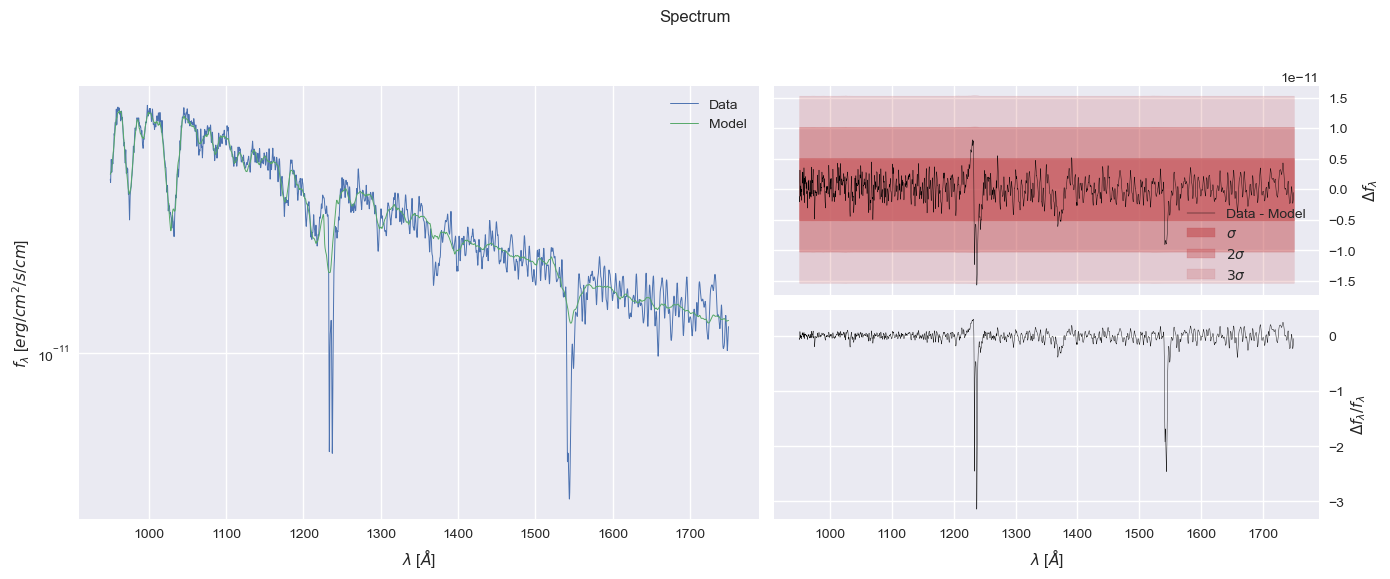

In [25]:
"""12 Saving and plotting the trained model"""
model.plot()
model.save("KWD_Grid_full_ss_cyg_MAP_example.toml")
model.load("KWD_Grid_full_ss_cyg_MAP_example.toml")
model.freeze("global_cov")
model.labels

#### <u>Stage 13 - Setting Up Initial Walkers's Position for MCMC</u>


This code block initialises the walker positions for the MCMC with a gaussian ball. The MCMC sampler used is `emcee`. The multiprocessing environment is set with this stage for emcee using the pool process. 

-- You have 3 inputs here! --

The code reads the number of CPU's within your machine and the pooling process will use X-2 for multiprocessing. You can change this if you wish by altering `ncpu = cpu_count() - 2` integer value.

You can now set the number of walkers you wish for the MCMC with `nwalkers`. For processing efficiency, use a multiple of the CPU-2 integer. Eg, $nwalkers = 5\times(CPU-2)$. `max_n` controls the maximum number of steps the MCMC takes. Set this to a high number like 1000 as the code will auto-break when convergence is reached. The `emcee` has a backend too. So if convergence isn't met after maximum steps, you can keep running the sampler in Stage 15 again and again to continue the process from where you left off. The MCMC dimensionality is set for you (`ndim`)with how many unfrozen model parameters you have.

The gaussian ball.... to be continued. 

In [ ]:
"""13 Set our walkers and dimensionality"""

os.environ["OMP_NUM_THREADS"] = "1"
import multiprocessing as mp
mp.set_start_method('fork', force=True)

### ----- Inputs here ------|
ncpu = cpu_count() - 2      # Pool CPU's used. 
nwalkers = 5 * ncpu         # Number of walkers in the MCMC.
max_n = 1000                # Maximum iterations of the MCMC if convergence is not reached. 
### ------------------------|

ndim = len(model.labels)
print("{0} CPUs".format(ncpu))
# Initialize gaussian ball for starting point of walkers
scales = {"c1": 1e-10, "c2": 1e-2, "c3": 1e-2, "c4": 1e-2}
#model = model_ball_initial
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

#### <u>Stage 14 - Running the MCMC</u>

This code block executes the MCMC run. Starfish samples the chains every 10 iterations to check for convergence. If converged, the code will break and complete the MCMC before the max iterations set in Stage 13. 

The `log_prob(...)` function is defined which returns the natural logarithm of the posterior probability. The function is set so if for any reason the sampler attempts to go outside your grid space, the probability is return negative infinity. The emcee backend file is setup in .HDF5 format. 

In [ ]:
"""14 Our objective to maximize and set up our backend/sampler"""

def log_prob(P, priors):
    range_min = np.array([1e-10, 4, 0]) #limiting walkers to the grid space
    range_max = np.array([3e-9, 32, 1])
    if np.any(P < range_min) or np.any(P > range_max):
        return -np.inf
    else:
        model.set_param_vector(P)
        return model.log_likelihood(priors)

backend = emcee.backends.HDFBackend("KWD_Grid_full_ss_cyg_chain_example.hdf5")
backend.reset(nwalkers, ndim)

with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend, pool=pool
    )

    index = 0 # Tracking how the average autocorrelation time estimate changes
    autocorr = np.empty(max_n)

    old_tau = np.inf # This will be useful to testing convergence

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue
            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
            # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
            # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau


#### <u>Stage 15 - Run More MCMC!</u>

The code block executes more MCMC steps after convergence to ensure clean chains or run more steps if convergence hasn't been reached yet. It's recommended to run this stage at least once for a given MCMC run. 

-- You have one input here! --

`extra steps` - controls the number of extra MCMC steps you want. Default set as 10% the maximum number of steps set (`max_n`). 

In [ ]:
"""15 Running extra mcmc steps post-convergence to check clean chains."""
### --- Inputs here ----|
extra_steps = max_n/10  # Extra MCMC steps
### --------------------|
sampler.run_mcmc(backend.get_last_sample(), extra_steps, progress=True)

#### <u>Stage 16 - Plotting the Raw MCMC Chains</u>

This code block shows the plot trace of the MCMC chains, direct from the MCMC process. 

In [ ]:
"""16 Showing raw MCMC chain."""
reader = emcee.backends.HDFBackend("KWD_Grid_full_ss_cyg_chain_example.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)
flatchain = reader.get_chain(flat=True)
print(flatchain)
az.plot_trace(full_data)

#### <u>Stage 17 - Discarding the Burn-In Section of the Chains</u>

This code block discards the burn-in period of the MCMC chains. the period is set as .... We flatten the chain (understand...)

In [ ]:
"""17 Discarding MCMC burn-in."""
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

#### <u>Stage 18 - Plotting the Cleaned MCMC Chains</u>

This code block plots again the trace of the MCMC chains with the burn-in period removed. Summary statistics are also provided from the MCMC.

In [ ]:
"""18 Plotting the mcmc chains without the burn-in section,
   summarise our mcmc run's parameters and analysis,
   plot our posteriors of each paramater, 
   produce a corner plot of our parameters."""
az.plot_trace(burn_data);
az.summary(burn_data, round_to=None)
az.plot_posterior(burn_data, ["c1", "c2", "c3", "c4"]);

#### <u>Stage 19 - Producing a Cornerplot of the Parameters</u>

In [ ]:
"""19 Producing a corner plot of our parameters."""
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 3)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True,
)

#### <u>Stage 20 - Examining the Best Fit Values from the MCMC</u>

In [ ]:
"""20 We examine our best fit parameters from the mcmc chains,
   plot and save our final best fit model spectrum."""
ee = [np.mean(burn_samples.T[i]) for i in range(len(burn_samples.T))]
ee = dict(zip(model.labels, ee))
#best_fit = dict(az.summary(burn_data, round_to=None)["mean"])
model.set_param_dict(ee)
model
model.plot();
model.save("KWD_Grid_full_ss_cyg_sampled_example.toml")